In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
df = pd.read_parquet(r"C:\Users\Home\Documents\EPFL\ML\Project2\All_Relative_Results_Cleaned.parquet")

In [3]:
label_encoder = LabelEncoder()

df_clean = df.dropna()
index = df_clean.columns.get_loc('time(s)')
df_right = df_clean.iloc[:, index:]
X = df_right
add_participants = df_clean['Participant']
add_camera = df_clean['Camera']
add_participants_encoded = label_encoder.fit_transform(add_participants)
add_camera_encoded = label_encoder.fit_transform(add_camera)
Y = df_clean['Exercise']

In [4]:
X = X.assign(add_participants_encoded=add_participants_encoded, add_camera_encoded=add_camera_encoded)
print(X)


       time(s)  left_ankle_x  left_ankle_y  left_ankle_z  left_ear_x  \
0     0.000000      0.009328      0.779305      0.187880    0.020658   
1     0.033333      0.009353      0.779298      0.185050    0.021187   
2     0.066667      0.009722      0.779311      0.179212    0.021351   
3     0.100000      0.011696      0.778027      0.166566    0.023431   
4     0.133333      0.011671      0.778045      0.166878    0.023658   
..         ...           ...           ...           ...         ...   
730  24.333333      0.104921      0.764555      0.082647    0.058097   
731  24.366667      0.104855      0.764961      0.084220    0.058165   
732  24.400000      0.105392      0.765160      0.084043    0.058210   
733  24.433333      0.106408      0.765264      0.084009    0.059145   
734  24.466667      0.106992      0.765289      0.083549    0.059338   

     left_ear_y  left_ear_z  left_elbow_x  left_elbow_y  left_elbow_z  ...  \
0     -0.693419    0.023043     -0.023044     -0.472627  

In [5]:
Y_encoded = label_encoder.fit_transform(Y)

In [6]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(Y_encoded, dtype=torch.long)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, y_tensor, test_size=0.2)

train_dataset = TensorDataset(X_train,Y_train)
test_dataset = TensorDataset(X_test,Y_test)
trainLoader = DataLoader(train_dataset, batch_size=32, shuffle=False)
testLoader = DataLoader(test_dataset, batch_size=32 , shuffle=False)

In [8]:
class GRUNeuralNetwork(nn.Module):
    def __init__(self):
        super(GRUNeuralNetwork, self).__init__()
        self.gru = nn.GRU(X_train.shape[1], 64)#, batch_first=True)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 7)

    def forward(self, x):
        # x est de la forme (batch_size, sequence_length, input_size)
        output, _ = self.gru(x)
        # Prenez seulement la sortie de la dernière étape de la séquence
        #output = output[:, -1, :]
        output = self.relu(output)  
        output = self.layer2(output)
        return output
model = GRUNeuralNetwork()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
model.train()

for epoch in range(50):  # 4 is the nbr of epochs
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for inputs, labels in trainLoader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainLoader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Époque {epoch + 1}, Perte: {epoch_loss:.4f}, Exactitude: {epoch_accuracy:.2f}%')


Époque 1, Perte: 0.1609, Exactitude: 93.29%
Époque 2, Perte: 0.1251, Exactitude: 94.52%
Époque 3, Perte: 0.1183, Exactitude: 94.80%
Époque 4, Perte: 0.1144, Exactitude: 94.97%
Époque 5, Perte: 0.1125, Exactitude: 95.05%
Époque 6, Perte: 0.1108, Exactitude: 95.11%
Époque 7, Perte: 0.1091, Exactitude: 95.20%
Époque 8, Perte: 0.1080, Exactitude: 95.24%
Époque 9, Perte: 0.1070, Exactitude: 95.29%
Époque 10, Perte: 0.1059, Exactitude: 95.33%
Époque 11, Perte: 0.1050, Exactitude: 95.40%
Époque 12, Perte: 0.1045, Exactitude: 95.42%
Époque 13, Perte: 0.1042, Exactitude: 95.43%
Époque 14, Perte: 0.1036, Exactitude: 95.46%
Époque 15, Perte: 0.1029, Exactitude: 95.48%
Époque 16, Perte: 0.1024, Exactitude: 95.51%
Époque 17, Perte: 0.1022, Exactitude: 95.53%
Époque 18, Perte: 0.1016, Exactitude: 95.56%
Époque 19, Perte: 0.1014, Exactitude: 95.57%
Époque 20, Perte: 0.1012, Exactitude: 95.56%
Époque 21, Perte: 0.1011, Exactitude: 95.57%
Époque 22, Perte: 0.1016, Exactitude: 95.54%
Époque 23, Perte: 0

In [15]:
model.eval()  # Mettre le modèle en mode évaluation
total_test = 0
correct_test = 0

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in testLoader:
        labels = labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Exactitude sur l\'ensemble de test: {test_accuracy}%')

Exactitude sur l'ensemble de test: 95.8621195016224%


Text(52.722222222222214, 0.5, 'True labels')

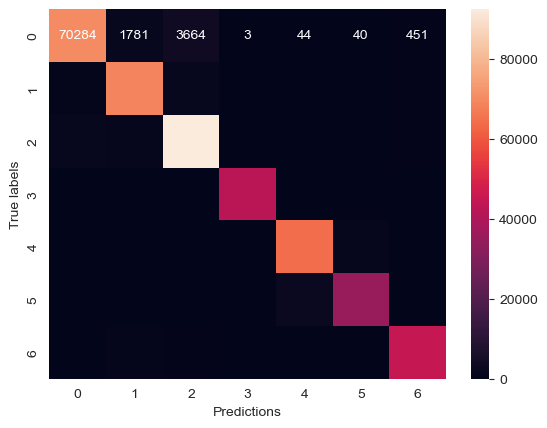

In [16]:
conf_matrix = confusion_matrix(y_true,y_pred)

sns.heatmap(conf_matrix, annot=True, fmt = 'd')
plt.xlabel('Predictions')
plt.ylabel('True labels')

In [13]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.92      0.94     76267
           1       0.95      0.95      0.95     72288
           2       0.94      0.97      0.95     95749
           3       1.00      1.00      1.00     42384
           4       0.97      0.98      0.97     65549
           5       0.96      0.94      0.95     37526
           6       0.97      0.96      0.96     46934

    accuracy                           0.96    436697
   macro avg       0.96      0.96      0.96    436697
weighted avg       0.96      0.96      0.96    436697
